# Computational Social Science Project #2 

*Group number:* 5

*Group members:* Alonzo Ackerman, Christopher Crawford, Annie Helms    

*Semester:* Fall 2021


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send KQ a pull request on GitHub flagging the syntax that's tripping you up 

## 1. Introduction/Setup

#### a) Import relevant libraries
Add the other libraries you need for your code below and/or as you go. 

In [1]:
# import libraries you might need here 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. 

In [2]:
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv', delimiter = ',' , 
                
                       #CountyFips needs to be a string so leading 0 isn't dropped (this is only if you want to make choropleth map): 
                       dtype={"CountyFIPS": str}) 


In [3]:
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.size) 

shape:  305900


In [4]:
pd.set_option('display.max_rows', 100) # tells pandas how many rows to display when printing so results don't get truncated

# look at the data types for each column in diabetes df 
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [6]:
# Now do the same as above, but for "Obesity_Number" :
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique())


['No Data']


The values contained in the two columns above making them objects (rather than integers) appear to be strings like "No Data" and "Suppressed." Let's drop those rows in the next section, and also recode Physical_Inactivity_Number to be an integer. 

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' to. 

In [7]:
# Diabetes
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 


# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype('int64', copy=False) 

# Obesity 
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype('int64', copy=False)


# Physical Inactivity
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype('int64', copy=False)

# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]
# change to numeric (specifically, integer or float?) from string (because originally included the "-" )
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype('float64', copy=True)


We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [8]:
# select count variables to rc to percentages; make sure we leave out ratios and our population variable b/c these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'sex and age_total population_sex ratio (males per 100 females)', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') # recode all selected columns to numeric

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [9]:
pd.set_option('display.max_columns', None)
# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. 

In [10]:
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_two or more races_1',
 'hispanic or latino and race_total population',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'race_total population_one race_1']

In [11]:
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=(duplicateColumnNames))

## 2. Exploratory Data Analysis

In [12]:
# insert your EDAs and interpretations in this section 

### Annie's Exploratory Data Analysis:

I will create a chloropleth map of the USA with scaled diabetes number across each county. To create this map, the following libraries should be installed and imported.

In [13]:
# uncomment to install required packages
#!pip install -U plotly
#!pip install -U dash
#!pip install -U kaleido

In [14]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
    
# This file contains geometry information for US counties, with corresponding FIPS code as column 'id'
counties["features"][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]},
 'id': '01001'}

In [15]:
# import packages for plotting
import kaleido
import plotly.express as px
import plotly.io as pio

In [16]:
fig = px.choropleth(diabetes, geojson=counties, locations='CountyFIPS', color='Diabetes_Number',
                           color_continuous_scale="Viridis",
                           range_color=(0, 0.2),
                           scope="usa",
                           labels={'Diabetes_Number':'Rate of Diabetes',
                                  'CountyFIPS': 'County ID'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# fig takes too long to render, so written to new file which will open when the cell is run
# note, as this file 'saves' each time the cell is run, the file name has been added to a .gitignore file
fig.write_html("eda_annie_plot.html", auto_open=True)

Based on the chloropleth figure, there appears to be a relationship between geography and the diabetes rate. In general, there are higher rates of diabetes in the southeastern states of the country, including Louisiana, Mississippi, Alabama, Georgia, South Carolina, and North Carolina. The figure suggests that community-wide factors, such as culture and social networks, may have an influence upon the rate of diabetes in addition to individual-level factors, such as age and physical inactivity.

### Chris's Exploratory Data Analysis:

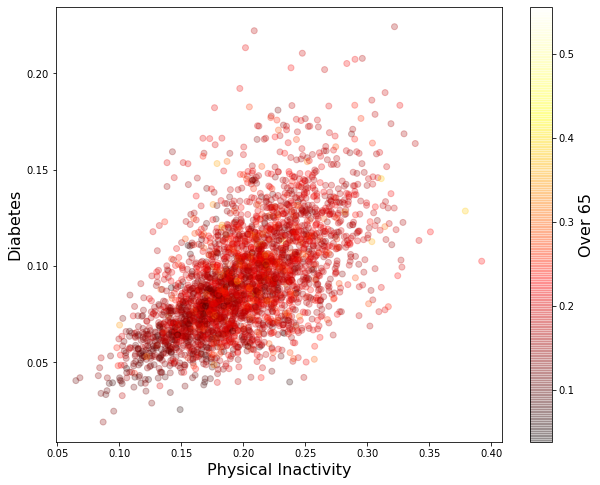

In [17]:
plt.figure(figsize=(10, 8)) #set figure size

plt.scatter(diabetes["Physical_Inactivity_Number"], 
            diabetes["Diabetes_Number"],
            marker = "o",
            alpha = 0.25,
            c = diabetes["sex and age_total population_65 years and over"], #change colors
            cmap = "hot")
plt.xlabel("Physical Inactivity", fontsize = 16)
plt.ylabel("Diabetes", fontsize = 16)
plt.colorbar().set_label("Over 65", fontsize=16)

As shown in the scatterplot above, there is a strong relationship between physical inactivity and diabetes, with higher levels of physical inactivity being associated with greater diabetes. The color of each observation represents the percentage of the population over the age of 65, and it appears that counties with younger populations (darker colors) have lower levels of diabetes and lower levels of physical inactivity. 

### Alonzo's Exploratory Data Analysis

I present information on the White, Black and Latinx population (of any race).

In [18]:
from matplotlib import pyplot as plt
import numpy as np

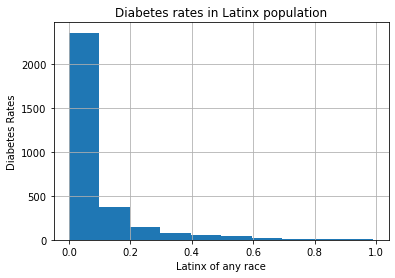

In [19]:
diabetes.hist('hispanic or latino and race_total population_hispanic or latino (of any race)')
plt.title('Diabetes rates in Latinx population')
plt.xlabel('Latinx of any race')
plt.ylabel('Diabetes Rates')

# Show plot
plt.show()

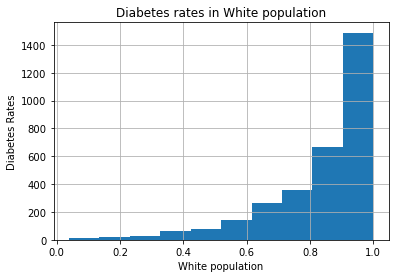

In [20]:
diabetes.hist('race_total population_one race_white')
plt.title('Diabetes rates in White population')
plt.xlabel('White population')
plt.ylabel('Diabetes Rates')
 
# Show plot
plt.show()

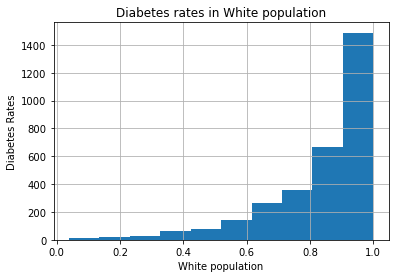

In [21]:
diabetes.hist('race_total population_one race_white')
plt.title('Diabetes rates in White population')
plt.xlabel('White population')
plt.ylabel('Diabetes Rates')
 
# Show plot
plt.show()

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'State' to be a categorical variable using `pd.get_dummies` and drop 'County' using `.drop()` because 'CountyFIPS' is already a unique identifier for the county. 

In [22]:
# create dummy features out of 'State' , which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['State'],  
                               drop_first = True) # only create 49 dummies by dropping first in category

# drop 'County' variable
diabetes_clean = diabetes_clean.drop(labels = ['County'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2/3.3 Partition Data and Feature Selection

Now, we will partition our data to prepare it for the training process. We will use 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

In [23]:
from sklearn.model_selection import train_test_split

# Set y 
y = diabetes_clean['Diabetes_Number']

# X (everything except diabetes, our target)
X = diabetes_clean.drop(["Diabetes_Number"], axis = 1)

We should also preprocess our data. Using the `preprocessing` module from sklearn, let's scale our features so that they are mean-centered.

In [24]:
from sklearn import preprocessing

X = preprocessing.scale(X)

We can also get rid of the 0 variance features using the `VarianceThreshold()` method from `feature_selection`. 

In [25]:
from sklearn import feature_selection

selector = feature_selection.VarianceThreshold(0)
X = selector.fit_transform(X)

And finally, let's split our data:

In [26]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.25)

## 4. Train Models

In [27]:
# train your three models in this section 

### Model 1: Linear Regression (OLS)

- Model Explanation and Logic

Linear regression algorithms can take an input of a set of predictor variables and predict the value of a continous output variable. OLS is fairly interpretable, where a coefficient is fitted to each predictor value, in a sense assigning the weight of the variable to the outcome. For the current data set, our outcome variable, `Diabetes_Number`, is a continuous value. Therefore, OLS is a logical choice for a model. However, OLS does not constraint the model coefficients in any way, or drop out variables that are not correlated to the outcome variable. As there are many predictor variables, the regression model will not be as interpretable as it could be if we were to use Ridge or LASSO regression.

- Train Model

The OLS model will be trained using the training set and hyperparameters will be tuned using `GridSearchCV`.

In [28]:
# import necessary libraries
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV

Define function to calculate the mean squared error:

In [29]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [30]:
# create a model
lin_reg = LinearRegression()

# tune hyperparameters
param_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']}

lin_grid_reg = GridSearchCV(lin_reg, param_grid, cv=3)
lin_grid_reg.fit(X_train, y_train)

best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)

print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lin_pred, y_validate))

{'fit_intercept': 'True', 'normalize': 'True'}
Best CV R^2: -4.503483324435879e+55
Validation R^2: 0.4472563273422243
Validation RMSE 0.020638326753823443


In [31]:
# recreate model, using selected hyperparameters
lin_reg = LinearRegression(fit_intercept=True, normalize=True)
lin_model = lin_reg.fit(X_train, y_train)

Obtain the coefficients for each predictor variable, and the intercept of the regression line:

In [32]:
print(lin_model.coef_)
print(lin_model.intercept_)

[ 1.81141509e-01  7.16741091e-03  7.12577033e-03  1.33564928e-04
  2.82047858e-05 -3.00206803e+10 -3.16455255e+10 -1.40466842e+10
 -1.20975791e+10 -6.41701948e+09  9.20039398e-04 -2.74186964e-04
  6.43244391e-04  4.71207551e-04 -1.23735939e+10  2.68397098e+09
  2.73834177e+09  4.24301881e+09  1.34639204e+09  9.74502447e+08
  1.14709093e+09  2.16644157e+09  9.59022337e+10 -6.69605311e+10
 -1.17976645e+10 -1.70133125e+10 -3.09459166e+10 -3.26402408e+09
 -4.02559731e-03 -1.20717776e-02 -7.99733904e-03  1.89101077e-03
  5.49083749e-02 -1.79150337e-01 -9.43492655e-02 -1.78948362e-02
 -1.96824538e-02 -5.39687044e-02 -5.40161368e+10  6.09188642e+10
  6.72566741e+09  3.95185101e+09  1.82632896e+10  2.55758700e+10
 -1.64907069e+10 -1.17651544e+10 -6.13793080e+09 -2.25364386e+09
 -3.15862112e+08 -1.88277858e+08 -1.85775120e+10  8.94032186e+08
  1.71097113e+10 -6.96399743e-05  1.39901631e+09 -9.52921574e+08
 -8.53599494e+08  2.50639621e+11  2.50639621e+11 -2.19000547e-02
  5.30509354e+09  5.30686

Obtain highest 10 (absolute value) coefficients:

In [33]:
# Create a dataframe with the coefficient and feature names
X_asdf = diabetes_clean.drop(["Diabetes_Number"], axis=1)
lin_reg_data = pd.DataFrame([lin_model.coef_, X_asdf.columns]).T
lin_reg_data.columns = ['Coefficient', 'Feature']
lin_reg_data = lin_reg_data.convert_dtypes()

In [34]:
lin_reg_data.head()

,Coefficient,Feature
57,2.506396e+11,citizen - voting age population_citizen - 18 and over population_female
58,2.506396e+11,sex and age_total population_male
22,9.590223e+10,race_total population_one race_native hawaiian and other pacific islander
23,-6.696053e+10,race_total population_one race_native hawaiian and other pacific islander_native hawaiian
39,6.091886e+10,hispanic or latino and race_total population_hispanic or latino (of any race)
76,5.979368e+10,sex and age_total population_16 years and over
38,-5.401614e+10,race alone or in combination with one or more other races_total population_some other race
80,-5.199487e+10,sex and age_total population_65 years and over
81,-4.348861e+10,sex and age_total population_18 years and over_male
70,3.674866e+10,sex and age_total population_60 to 64 years


In [30]:
# create new col with absolute value of coefficient
pd.set_option('max_colwidth', 400)
lin_reg_data['abs_coef'] = abs(lin_reg_data['Coefficient'])

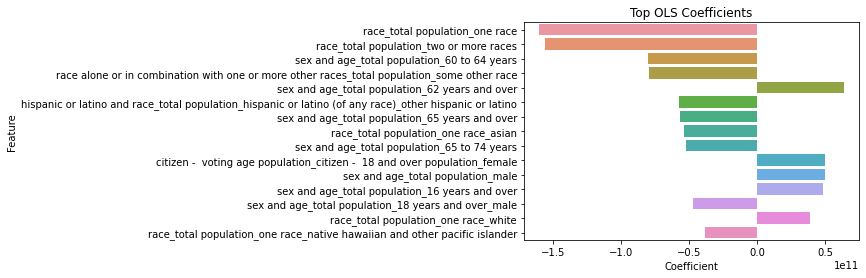

In [32]:
# plot 15 largest coefficients
sns.barplot(x="Coefficient", y="Feature", data=lin_reg_data.nlargest(15, 'abs_coef')).set_title("Top OLS Coefficients")
plt.show()

Calculate root means squared error to evaluate how well the model fits the training data (what is the difference between the predicted values and the training values)

In [35]:
# predict the rate of diabetes
lin_pred = lin_model.predict(X_train)
rmse(lin_pred, y_train)

0.019137431927081748

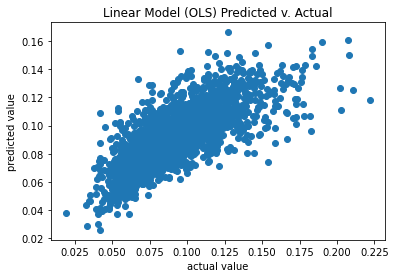

In [36]:
# now a visual examination

# plot the residuals on a scatter plot
plt.scatter(y_train, lin_pred)
plt.title('Linear Model (OLS) Predicted v. Training')
plt.xlabel('training value')
plt.ylabel('predicted value')
plt.show()

If we imagine a best fit line for the plot above, the slope of the line would be pretty close to 1, meaning that the OLS model is a very good predictor for the training data (as we would expect). 

### Model 2: Ridge Regression

Like OLS, ridge regression estimates parameters that minimize the sum of the squared residuals; however, unlike OLS, ridge regression also seeks to minimize the sum of the squared coefficients, as a function of a tuning parameter. The rationale behind ridge regression is that by shrinking the estimates toward zero, the variance of the estimated model is reduced. Moreover, ridge regression is particularly well suited to models consisting of a larger number of predictors.\

The value of tuning parameter will be selected using the `GridSearceCV()` method. Values between 0.1 and 1 (in increments of 0.1) will be considered.

In [37]:
# RIDGE: 

#initialize model
ridge_reg = Ridge() 

param_grid = {'alpha': np.arange(.1, 1, .1),
              'normalize': ['True', 'False'],
              'fit_intercept': ['True', 'False'],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3)
ridge_grid_reg.fit(X_train, y_train)

best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)

print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

{'alpha': 0.9, 'fit_intercept': 'True', 'normalize': 'True', 'solver': 'svd'}
Best CV R^2: -68.56205979434951
Validation R^2: 0.4981714376554003
Validation RMSE 0.0196648338911471


The hyperparameters for the best fitting model are shown above. The tuning parameter, denoted as alpha, for the best fitting model has a value of 0.9. The validation RMSE is 0.020, which is slightly better than the OLS validation RMSE of 0.021. The best fitting ridge model is also explaining more validation variance (50%) than the OLS model (45%).

In [38]:
# recreate model, using selected hyperparameters
ridge_reg = Ridge(alpha=0.9, fit_intercept= True, normalize= True, solver= 'svd')
ridge_model = ridge_reg.fit(X_train, y_train)

In [39]:
print(ridge_model.coef_)
print(ridge_model.intercept_)

[-1.33392330e-04  4.21713003e-03  4.31135908e-03 -6.72152727e-04
 -2.61663392e-04  1.84552092e-05 -1.84552092e-05 -1.07807460e-03
  1.26549138e-03  1.87708514e-04  6.29565265e-04 -2.09791550e-05
  2.45199525e-04  3.78851363e-04 -3.50537640e-04 -5.35822058e-04
 -3.33167524e-04  6.71958332e-06  1.93739814e-04 -4.92661625e-04
 -2.97642122e-04 -3.84689838e-04  2.86032755e-05  1.19528107e-04
  1.75420788e-04 -1.33081025e-04 -1.20509558e-04 -1.76134364e-04
  4.73012412e-04  6.27468548e-05 -1.38220470e-03  3.90906980e-04
 -1.09216540e-03  1.26413700e-03  1.71510753e-04 -4.72623432e-04
  1.83595325e-05 -1.36485020e-04 -1.28677646e-04  5.81173998e-05
 -2.43874830e-04 -2.99714130e-04 -5.00203557e-04  1.28677646e-04
 -8.36407172e-04  1.25561510e-03  2.08080250e-04 -3.60408716e-04
  6.18410352e-05  7.97893384e-05  7.03398952e-05 -6.28575640e-05
  7.38052885e-05 -1.76263254e-04  3.24253213e-04  1.75104772e-04
  3.34665106e-04 -1.03166003e-04  1.03166003e-04 -1.54213619e-04
 -3.88999368e-04 -5.82088

In [40]:
# Create a dataframe with the coefficient and feature names
X_names = diabetes_clean.drop(["Diabetes_Number"], axis=1)
ridge_reg_params = pd.DataFrame([ridge_model.coef_, X_names.columns]).T
ridge_reg_params.columns = ['Coefficient', 'Feature']
ridge_reg_params = ridge_reg_params.convert_dtypes()

In [41]:
# sort dataframe and show highest 15 absolute value rows
pd.set_option('max_colwidth', 400)
ridge_reg_params_sorted = ridge_reg_params.reindex(ridge_reg_params.Coefficient.abs().sort_values(ascending=False).index)
ridge_sorted = ridge_reg_params_sorted.head(15)
ridge_sorted

,Coefficient,Feature
2,0.004311,Physical_Inactivity_Number
1,0.004217,Obesity_Number
132,0.001416,State_Washington
30,-0.001382,race_total population_two or more races_white and asian
8,0.001265,race_total population_one race_black or african american
33,0.001264,race alone or in combination with one or more other races_total population_white
45,0.001256,hispanic or latino and race_total population_not hispanic or latino_white alone
89,-0.001157,State_California
32,-0.001092,race alone or in combination with one or more other races_total population
7,-0.001078,race_total population_one race_white


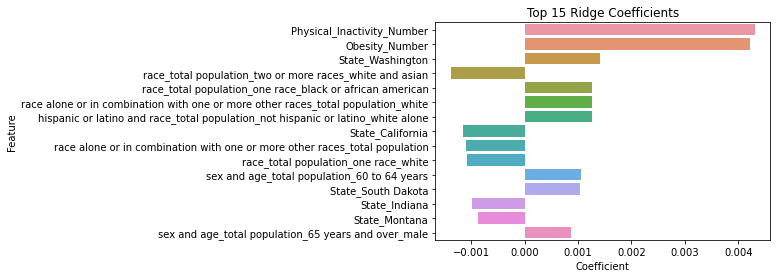

In [42]:
# Plot coefficients
ax = sns.barplot(x = "Coefficient", y = "Feature", data = ridge_sorted)
ax.set_title("Top 15 Ridge Coefficients")
plt.show()

As shown in the table and barplot above, the coefficients for `Physical_Inactivity_Numer` and `Obestity_Number` are the largest, suggesting that those two variables are the best predictors of `Diabetes_Number`.

The ridge RMSE for the training data is listed below, and is slightly larger than the OLS RMSE (0.020 vs. 0.019)

In [43]:
# predict the rate of diabetes
ridge_pred = ridge_model.predict(X_train)
rmse(ridge_pred, y_train)

0.020139010345765363

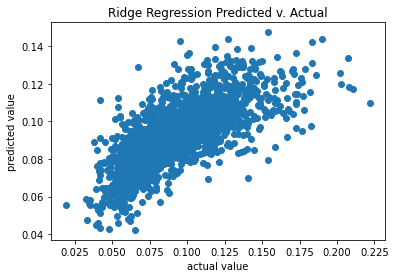

In [44]:
# plot actual vs predicted values
plt.scatter(y_train, ridge_pred)
plt.title('Ridge Regression Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

As shown in the scatterplot above, the actual values for `Diabetes_Number` in the training data and the values predicted by the ridge model are strongly correlated.

### Model 3: LASSO Regression

Like ridge regression, the LASSO estimates paramters that minimize both the sum of the squared residuals and a shrinkage penalty, but whereas the penalty for ridge regression is the sum of the squared coeffiecent estimates, the penalty for the LASSO is the sum of the absolute values of the coefficient estimates. This has the desirable property of shrinking some coefficent estimates to zero when the tuning paramter is sufficiently large. Thus, in addition to improving upon OLS by reducing the variance of the estimated model, the LASSO also performs feature selection by forcing some estimates to be zero.

In [45]:
# LASSO: 

#initialize model
lasso_reg = Lasso(max_iter=10000) 

param_grid = {'alpha': np.arange(.01, 1, .01),
              'normalize': ['True', 'False'],
              'fit_intercept': ['True', 'False'],
              'selection': ['cyclic', 'random']}

lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3)
lasso_grid_reg.fit(X_train, y_train)

best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)

print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

{'alpha': 0.01, 'fit_intercept': 'True', 'normalize': 'True', 'selection': 'cyclic'}
Best CV R^2: -0.0014479879063390804
Validation R^2: -0.0004956340499586709
Validation RMSE 0.027766439466639033


As shown above, the best fitting LASSO model features a tuning parameter value of 0.01. However, the validation R^2 is negative, suggesting that something is wrong with the model. Moreover, the validation RMSE is larger than that of the ridge and OLS models.

In [46]:
# recreate model, using selected hyperparameters
lasso_reg = Lasso(alpha = 0.01, fit_intercept = True, normalize = True, selection = "cyclic")
lasso_model = lasso_reg.fit(X_train, y_train)

In [47]:
print(lasso_model.coef_)
print(lasso_model.intercept_)

[-0.  0.  0. -0. -0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0.  0.  0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0.  0.
  0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0. -0. -0.
 -0.  0. -0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0.
  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0.  0. -0.
  0. -0. -0. -0.  0. -0.  0. -0. -0.]
0.09280115686958552


As shown above and in the table below, all coefficient estimates in this LASSO model have been shrunken to zero. 

In [48]:
# Create a dataframe with the coefficient and feature names
X_names = diabetes_clean.drop(["Diabetes_Number"], axis=1)
lasso_reg_params = pd.DataFrame([lasso_model.coef_, X_names.columns]).T
lasso_reg_params.columns = ['Coefficient', 'Feature']
lasso_reg_params = lasso_reg_params.convert_dtypes()

In [49]:
# sort dataframe and show highest 15 absolute value rows
pd.set_option('max_colwidth', 400)
lasso_reg_params_sorted = lasso_reg_params.reindex(lasso_reg_params.Coefficient.abs().sort_values(ascending=False).index)
lasso_sorted = lasso_reg_params_sorted.head(15)
lasso_sorted

,Coefficient,Feature
134,0,State_Wisconsin
49,0,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone
35,0,race alone or in combination with one or more other races_total population_american indian and alaska native
36,0,race alone or in combination with one or more other races_total population_asian
37,0,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander
38,0,race alone or in combination with one or more other races_total population_some other race
39,0,hispanic or latino and race_total population_hispanic or latino (of any race)
40,0,hispanic or latino and race_total population_hispanic or latino (of any race)_mexican
41,0,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican
42,0,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban


In [50]:
# predict the rate of diabetes
lasso_pred = lasso_model.predict(X_train)
rmse(lasso_pred, y_train)

0.028280215942562612

The training RMSE for this LASSO model is larger than that of the ridge and OLS models.

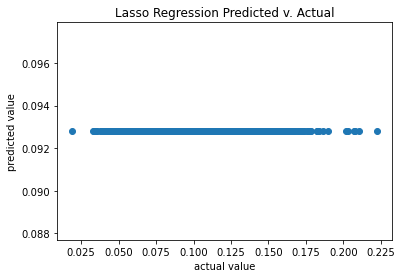

In [51]:
# plot actual vs predicted values
plt.scatter(y_train, lasso_pred)
plt.title('Lasso Regression Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

As shown in the scatter plot above, since this LASSO model estiamted all coefficients as zero, the predicted value for each observation is simply the intercept, which can is also the mean of the `Diabetes_Number` training data.

## 5. Validate and Refine Models

In [52]:
# use X_validation and y_validation data sets to evaluate and refine your models

### Model 1: OLS

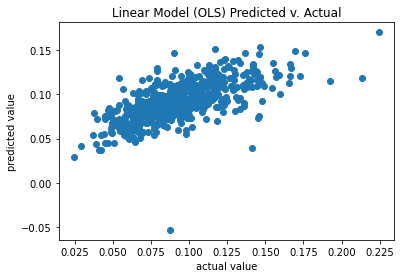

In [53]:
# predict the number of riders
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)
plt.title('Linear Model (OLS) Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

If this OLS model was 100% accurate, the plot above would have a slope of 1, where every predicted value would match up with every actual value in the set.

Now we can calculate the mean squared error for the model, using the validation data.

In [54]:
rmse(lin_pred, y_validate)

0.020638326753823443

### Model 2: Ridge

In [55]:
# predict the rate of diabetes
ridge_pred = ridge_model.predict(X_validate)
rmse(ridge_pred, y_validate)

0.0196648338911471

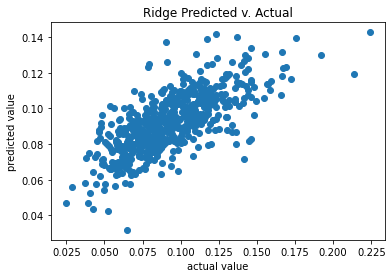

In [56]:
# plot actual vs predicted values
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

As shown by the RMSE estimate above, the ridge model fits the validation data slightly better than the OLS model.

### Model 3: Lasso

In [57]:
# predict the rate of diabetes
lasso_pred = lasso_model.predict(X_validate)
rmse(lasso_pred, y_validate)

0.027766439466639033

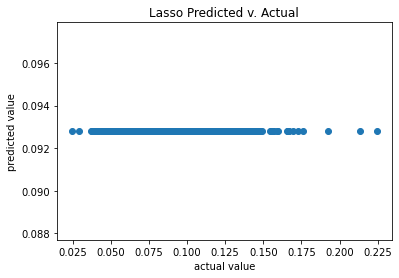

In [58]:
# plot actual vs predicted values
plt.scatter(y_validate, lasso_pred)
plt.title('Lasso Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

Of the three models considered, the LASSO is the worst fitting model, with an RMSE of 0.028 for the validation data. 

### Feature Selection

In [59]:
#Feature Selection

# sort dataframe and show highest 10 absolute value rows
pd.set_option('max_colwidth', 400)
ridge_reg_params_sorted = ridge_reg_params.reindex(ridge_reg_params.Coefficient.abs().sort_values(ascending=False).index)
ridge_sorted = ridge_reg_params_sorted.head(10)
ridge_sorted

,Coefficient,Feature
2,0.004311,Physical_Inactivity_Number
1,0.004217,Obesity_Number
132,0.001416,State_Washington
30,-0.001382,race_total population_two or more races_white and asian
8,0.001265,race_total population_one race_black or african american
33,0.001264,race alone or in combination with one or more other races_total population_white
45,0.001256,hispanic or latino and race_total population_not hispanic or latino_white alone
89,-0.001157,State_California
32,-0.001092,race alone or in combination with one or more other races_total population
7,-0.001078,race_total population_one race_white


In [60]:
list(ridge_sorted.index) #obtain the indices for selected features

[2, 1, 132, 30, 8, 33, 45, 89, 32, 7]

In [61]:
X_train_reduced = X_train[:,list(ridge_sorted.index)]
X_train_reduced.shape #check to make sure the correct number of features are included

(1866, 10)

In [62]:
ridge_model = ridge_reg.fit(X_train_reduced, y_train) #fit ridge model on reduced dataset

In [63]:
print(ridge_model.coef_)
print(ridge_model.intercept_)

[ 0.00597645  0.00478097  0.00159086 -0.00246337  0.00153286  0.00150231
  0.00155861 -0.00100122 -0.0004921  -0.00052779]
0.09267041750062907


In [64]:
ridge_pred = ridge_model.predict(X_train_reduced)
rmse(ridge_pred, y_train) #calculate RMSE for reduced model

0.021630092295253412

As shown above, the training RMSE for the reduced ridge model is 0.022, which is higher than the RMSE for the full ridge model.

### Testing Data

The best performing model of the 4 examined (OLS, ridge, LASSO, feature-selected ridge), based on validation RMSE, is the full ridge regression model. We will now assess the fit of this model with the testing data.

In [65]:
# recreate model, using selected hyperparameters
ridge_reg = Ridge(alpha=0.9, fit_intercept= True, normalize= True, solver= 'svd')
ridge_model = ridge_reg.fit(X_train, y_train)

#predicted values using test data 
ridge_pred = ridge_model.predict(X_test)
rmse(ridge_pred, y_test)

0.020294161154429384

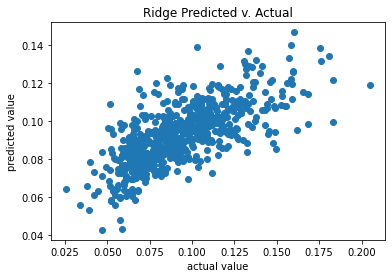

In [66]:
# plot predicted vs. actual for test data
plt.scatter(y_test, ridge_pred)
plt.title('Ridge Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

The RMSE for the ridge model as applied to testing data is 0.0203, which is slightly higher than the RMSE from the ridge model applied to the validation data (0.0197), but smaller than the RMSE from the OLS model applied to the validation data (0.0206).

The advantage of using both a validation dataset and a testing dataset is that the models can be tuned and adjusted using both the training and validation datasets, and the true predictive validity of the model can then be examined on the testing dataset, which plays no role in the training of the models.

### Cross-Validation

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

ridge_reg = Ridge(alpha=0.9, fit_intercept= True, normalize= True, solver= 'svd') #best ridge model

cv_size = np.arange(3,11,1) #different cv sizes

for size in cv_size: #iterate over the different sizes and compute the average RMSE
    ridge_pred = cross_val_score(ridge_reg, X, y, cv = size, scoring = "neg_mean_squared_error")
    print(size, ":", np.sqrt(abs(ridge_pred)).mean())

3 : 0.024370788527489955
4 : 0.025045177535753076
5 : 0.02556513144663087
6 : 0.02379789182441254
7 : 0.027173426461641864
8 : 0.04348050839242399
9 : 0.029634536110672596
10 : 0.033510122576898296


The best fitting cross-validation ridge model uses 6 folds. This model has an average RMSE of 0.238, which isl larger than the RMSE for the ridge model applied to the testing data. 

When considering the number of folds to use in the cross-validation approach, two concerns must be addressed: computational expense and bias-variance tradeoff. As the number of folds increase, the intensity of the computations increase, as a greater number of models are being fit. Regarding the bias-variance tradeoff, as the number of folds increase, bias decreases and variance increases. Thus, while a leave-one-out approach will result in a relatively unbiased estimate of the testing error, the estimate will have higher variance than an approach with a fewer number of folds. 

## 6. Discussion Questions

### 6.1 What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

Bias-variance tradeoff is the relationship between how much variance is present in a model and how much bias is present. It is ideal to have both low bias and low variance in a model, but that is often not possible. Bias is the error introduced by using a simpler model to approximate a more complex real-world problem, whereas variance is the amount that the prediction would change had it been estimated using a different training set. 

Bias-variance tradeoff is relevant to machine learning problems like this one because ideally, we want to create a model that is not too simple to yield high bias, but that is also not too complex to become uninterpretable. As the goal of incorporating machine learning into this question is to create new policy, it becomes important that we can draw clear conclusions from a model that is fairly transparent. Additionally, as the policymakers interested in looking at this data are interested in how diabetes rates compare across counties in the United States, it is very important that the data used for training are representative of national data and demographics. Otherwise, the model will have very high variance as predictions will be very sensitive to the training data.

### 6.2 Define overfitting and why it matters for machine learning. How can we address it?

Overfitting occurs when a model fits the training data excessively. Since it corresponds too closely to the training data, the model is unable to be effective with another data sample.  Machine learning models, thus, need not “overfit” the data to provide predictions with a different set of data. To address this issue we can rely on resampling techniques to estimate the accuracy of the model, like cross-validation.



### 6.3 Discuss your analysis in 2-3 paragraphs.